In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow as tf
import psycopg2
import pycaret
from pycaret.classification import *

## Load Data

In [2]:
# Connect to postgres SQL database
conn = psycopg2.connect(database = 'postgres',
                        user =     'postgres',
                        password = 'Arya7328*',
                        host =     'bootcampproject.cs8v5ggqsbn0.us-west-1.rds.amazonaws.com',
                        port =     '5432')

# Create cursor object
cur = conn.cursor()

# Select all data from machine learning table
cur.execute('''
            SELECT *
            FROM mltable;
            ''')

data = cur.fetchall()

# Create a dataframe
cols = []
for elt in cur.description:
    cols.append(elt[0])
        
health_df = pd.DataFrame (data=data,columns=cols)
pd.set_option('display.max_columns', None)
health_df.head(10)

,GENHLTH,MENTHLTH,PHYSHLTH,BPHIGH4,TOLDHI2,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,HAVARTH3,CHCKIDNY,DIABETE3,SEX,MARITAL,EDUCA,RENTHOM1,VETERAN3,EMPLOY1,INCOME2,INTERNET,QLACTLM2,USEEQUIP,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,_RFHLTH,_HCVU651,_RFHYPE5,_CHOLCHK,_RFCHOL,_MICHD,_LTASTH1,_ASTHMS1,_DRDXAR1,_PRACE1,_AGEG5YR,_BMI5,_BMI5CAT,_CHLDCNT,_EDUCAG,_INCOMG,_DRNKWEK,_RFDRHV5,_FRTLT1,_VEGLT1,PA1MIN_,_PACAT1,_PAINDX1,_PAREC1
0,2,88,30,3,2,2,2,2,2,2,2,2,2,3,2,2,6,2,2,1,8,1,1,1,2,2,1,2,1,1,1,1,2,1,2,1,3,2,1,5,2213,2,1,4,5,0.0,1,1,1,0.0,4,2,3
1,3,88,88,3,2,2,2,2,2,2,2,2,2,3,2,1,6,1,2,1,99,1,2,2,2,2,2,2,2,1,1,1,1,1,2,1,3,2,4,7,2317,2,1,4,99,99.0,99,1,99,60.0,3,2,4
2,1,88,88,3,2,2,2,2,1,2,2,2,2,3,2,6,6,1,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,1,2,1,3,2,1,4,2569,3,1,4,5,200.0,1,1,1,600.0,1,1,1
3,1,88,88,1,7,2,2,2,2,2,7,2,2,3,2,99,5,2,2,6,99,1,2,2,2,2,2,2,2,1,1,2,1,99,2,1,3,2,1,1,1997,2,1,3,99,0.0,1,99,1,90.0,99,99,99
4,3,7,15,3,2,2,2,2,2,2,2,2,2,3,2,5,6,2,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,1,2,2,2,2,1,2,2362,2,1,4,5,0.0,1,2,1,420.0,1,1,2
5,2,1,4,3,1,2,2,2,2,2,2,2,2,3,2,1,4,1,2,99,8,1,2,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,2,8,3328,4,1,2,5,0.0,1,1,1,105.0,3,2,4
6,3,15,88,3,2,2,2,2,2,2,2,2,2,3,2,5,3,2,2,2,4,1,2,2,2,1,2,2,2,1,1,1,1,1,2,1,3,2,2,4,2510,3,6,1,2,0.0,1,1,1,2610.0,1,1,1
7,3,88,10,3,1,2,2,2,2,2,2,2,2,1,1,1,5,1,2,2,8,1,1,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,1,99,3835,4,1,3,5,0.0,1,2,1,210.0,2,1,2
8,2,88,88,3,1,2,2,2,2,2,2,2,2,3,1,1,3,1,2,1,8,1,2,2,2,2,2,2,2,1,1,1,1,2,2,1,3,2,1,4,2500,3,2,1,5,140.0,1,2,2,196.0,2,1,1
9,2,88,88,3,2,2,2,2,2,2,2,2,2,3,1,5,5,3,2,6,99,1,2,2,2,2,2,2,2,1,1,1,1,1,2,2,1,2,1,1,2399,2,1,3,99,300.0,1,1,1,30.0,3,2,3


## Check Preprocessing

In [3]:
# Check size and shape of table
health_df.shape

(222168, 53)

In [4]:
# Check data types
health_df.dtypes

GENHLTH       int64
MENTHLTH      int64
PHYSHLTH      int64
BPHIGH4       int64
TOLDHI2       int64
CVDINFR4      int64
CVDCRHD4      int64
CVDSTRK3      int64
CHCSCNCR      int64
CHCOCNCR      int64
CHCCOPD1      int64
HAVARTH3      int64
CHCKIDNY      int64
DIABETE3      int64
SEX           int64
MARITAL       int64
EDUCA         int64
RENTHOM1      int64
VETERAN3      int64
EMPLOY1       int64
INCOME2       int64
INTERNET      int64
QLACTLM2      int64
USEEQUIP      int64
BLIND         int64
DECIDE        int64
DIFFWALK      int64
DIFFDRES      int64
DIFFALON      int64
_RFHLTH       int64
_HCVU651      int64
_RFHYPE5      int64
_CHOLCHK      int64
_RFCHOL       int64
_MICHD        int64
_LTASTH1      int64
_ASTHMS1      int64
_DRDXAR1      int64
_PRACE1       int64
_AGEG5YR      int64
_BMI5         int64
_BMI5CAT      int64
_CHLDCNT      int64
_EDUCAG       int64
_INCOMG       int64
_DRNKWEK    float64
_RFDRHV5      int64
_FRTLT1       int64
_VEGLT1       int64
PA1MIN_     float64


In [5]:
# Double check for null values
health_df.isna().sum().sum()

0

## Feature Engineering

### For numerical, ordered data, change none code (88) to 0, change did not respond code (99) to median of the feature, and bin values in skewed distributions

In [9]:
# GENHLTH: values over 5 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'GENHLTH'] > 5:
        health_df.loc[index, 'GENHLTH'] = health_df.GENHLTH.median()

In [10]:
# MENTHLTH: 88 changed to 0, 99 and over 30 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'MENTHLTH'] == 88:
        health_df.loc[index, 'MENTHLTH'] = 0
    elif (health_df.loc[index, 'MENTHLTH'] == 99) or (health_df.loc[index,'MENTHLTH'] > 30):
        health_df.loc[index, 'MENTHLTH'] = health_df.MENTHLTH.median()

In [11]:
# PHYSHLTH: 88 changed to 0, 99 and over 30 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, 'PHYSHLTH'] == 88:
        health_df.loc[index, 'PHYSHLTH'] = 0
    elif (health_df.loc[index, 'PHYSHLTH'] == 99) or (health_df.loc[index,'PHYSHLTH'] > 30):
        health_df.loc[index, 'PHYSHLTH'] = health_df.PHYSHLTH.median()

In [12]:
# _AGEG5YR: values over 13 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, '_AGEG5YR'] > 13:
        health_df.loc[index, '_AGEG5YR'] = health_df._AGEG5YR.median()

In [13]:
# For the following columns, values over 8 changed to median
change_cols = ['INCOME2', '_CHLDCNT', '_EDUCAG', '_INCOMG', '_PACAT1']
for col in change_cols:
    for index, row in health_df.iterrows():
        if health_df.loc[index, col] > 8:
            health_df.loc[index, col] = health_df[col].median()

KeyboardInterrupt: 

In [6]:
# _DRNKWEK: Values over 2000 changed to median
for index, row in health_df.iterrows():
    if health_df.loc[index, '_DRNKWEK'] > 2000:
        health_df.loc[index, '_DRNKWEK'] = health_df._DRNKWEK.median()

array([[<AxesSubplot:title={'center':'_DRNKWEK'}>]], dtype=object)

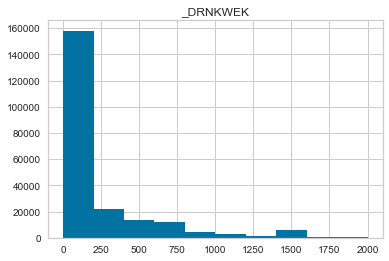

In [7]:
# Look at _DRNKWEK histogram
health_df.hist(column='_DRNKWEK')

array([[<AxesSubplot:title={'center':'_DRNKWEK'}>]], dtype=object)

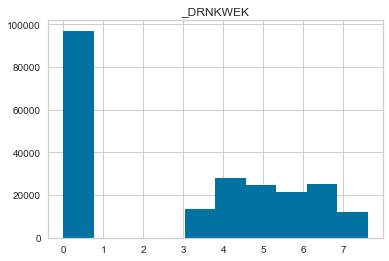

In [8]:
# Fix skew by taking log of _DRNKWEK
health_df['_DRNKWEK'] = np.log((health_df['_DRNKWEK']+1))

health_df.hist(column='_DRNKWEK')

In [ ]:
# Look at histogram of target (MentHlth) to decide bin ranges
health_df.hist(column='MENTHLTH')

In [ ]:
# Create 2 bins for mental health. One at 0, one from 1-30
for index, row in health_df.iterrows():
    if health_df.loc[index,'MENTHLTH'] > 0:
        health_df.loc[index, 'MENTHLTH'] = 1

In [ ]:
# Check target column bins
health_df.hist(column='MENTHLTH')

### For categorical variables, change type from int to categorical, then encode into columns of 0 and 1

In [ ]:
# Columns that need to be changed to categorical:
cat_cols = ['BPHIGH4','TOLDHI2','CVDINFR4','CVDCRHD4','CVDSTRK3','CHCSCNCR','CHCOCNCR','CHCCOPD1','HAVARTH3','CHCKIDNY', \
            'DIABETE3','SEX','MARITAL','EDUCA','RENTHOM1','VETERAN3','EMPLOY1','INTERNET','QLACTLM2','USEEQUIP', \
            'BLIND','DECIDE','DIFFWALK','DIFFDRES','DIFFALON','_RFHLTH','_HCVU651','_RFHYPE5','_CHOLCHK','_RFCHOL', \
            '_MICHD','_LTASTH1','_ASTHMS1','_DRDXAR1','_PRACE1','_RFDRHV5','_FRTLT1','_VEGLT1','_PAINDX1','_PAREC1']

for col in cat_cols:
    health_df[col] = health_df[col].astype('category')

In [ ]:
health_df.head(10)

In [ ]:
# Encode categorical columns

In [ ]:
# Save cleaned health_df to csv
health_df.to_csv("cleaned_health_df")

## Feature Selection

In [ ]:
# PyCaret Setup
# "Normalize = true" scales the data based on z-score
exp_clf101 = setup(data = health_df, target = 'MENTHLTH', session_id=123, normalize = True)

In [ ]:
# Create a random forest classifier
rf = create_model('rf')

In [ ]:
# Feature importance plot
plot_model(tuned_rf, plot='feature_all')

In [ ]:
# Remove lowest features
lowest_features = ['DIFFDRES','CVDINFR4','CVDCRHD4','CVDSTRK3','_MICHD','CHCKIDNY','BLIND','DIFFALON','USEEQUIP', \
                   'CHCCOPD1','_RFHLTH','_LTASTH1','DIFFWALK','_PAINDX1','_CHOLCHK','VETERAN3','_RFDRHV5','INTERNET', \
                   'HAVARTH3','_DRDXAR1','CHCOCNCR','_ASTHMS1','CHCSCNCR']

fs_health_df = health_df.drop(columns=lowest_features)

## Split Data and Setup PyCaret

In [ ]:
# Separate data into training and testing sets
data = fs_health_df.sample(frac=0.95, random_state=0).reset_index(drop=True)
data_unseen = fs_health_df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

In [ ]:
# PyCaret Setup
# "Normalize = true" scales the data based on z-score
exp_clf101 = setup(data = data, target = 'MENTHLTH', session_id=123, normalize = True)

## Compare Binary Classification Machine Learning Models

In [ ]:
# Model training and selection
best_model = compare_models()

In [ ]:
# Best performing model (by accuracy)
print(best_model)

In [ ]:
# Create gradient boosting classifier model
gbc = create_model('gbc')

## Tune Model and Analyze Performance

In [ ]:
# Automatically tune model parameters using PyCaret
tuned_gbc = tune_model(gbc)

In [ ]:
# Precision Recall Curve
plot_model(tuned_gbc, plot = 'pr')

In [ ]:
# Confusion Matrix
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [ ]:
# Predict using held-back test sample
predict_model(tuned_gbc);

In [ ]:
# Save the model
save_model(tuned_gbc,'Final_GBC_Model_3Sep22')